# 2024 유행어

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('../data_inword/2024년 유행어.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]

df.head()

,postdate,body,description,title
0,20240509,안녕하세요~ 말하는 #전화중국어 #화상중국어 전문 우리차이나입니다^^ 오늘은 여러분...,이상 <b>2024년<\/b> 새롭게 떠오르는 신조어들을 살펴봤는데요~ 다음에는 더...,[중국어 표현] 2024년 요즘 핫한 신조어(유행어) 3탄!!
1,20240503,(*타이틀 이미지 출처: PR TIMES) 안녕하세요! 일본에는 최근 어떤 것들이 ...,SNS <b>유행어<\/b> 랭킹 <b>2024년<\/b> 1Q 발표! 3위 <인플...,언제 봐도 재밌는 일본 최신 유행어(2024년 1분기 편)[일본 뉴스로 일본어 공부...
2,20240502,"제목: 2024년 대한민국 신조어 & 유행어 모음 안녕하세요, 여러분! 오늘은 20...",제목: <b>2024년<\/b> 대한민국 신조어 & <b>유행어<\/b> 모음 안녕...,올해의 트렌드를 알아볼 시간! 2024년 최신 유행어 모음
3,20240327,"안녕하세요 여러분~! 솔루셔니입니다:D 이번 IT Insight 주제는 ""멀티모달 ...",멀티모달 AI 시스템의 부상 <b>2024년<\/b> 인공지능의 환경은 멀티모달 A...,"2024년의 새로운 유행어, 멀티모달 AI"
4,20240412,#goat뜻 #savage뜻 #lit #ate #delulu #sus #onflee...,"이 밖에도 <b>2024년<\/b> 현재 일상대화, 소셜미디어, 인터넷 등에서 많이...","GOAT, LIT, SAVAGE … 2024년 현재 많이 쓰이는 영어 슬랭 유행어 ..."


## 1. 전처리

In [3]:
## 사용자 정의 단어 추가 
kiwi = Kiwi()

new = ['원영', '원영적 사고', '원영적', '원영적사고', '희진', '희진적사고', '개저씨', '모르면', '나가라', 
       '감성', '맛꿀마', '깔끼', '맛꿀쌉꿀마', '국가권력급', '꽁얼고걸', '꽁꽁', '얼어붙은', '한강', '고양이', 
       '캘박', '갓생', '술찌','오운완', '폭룡적', '자기야', '미안해', '자기야미안해', '했잖아', '이딴거', 
       '취존', '자만추', '점메추', '저메추', '중꺾마', '추구미', '디토', 
       '기절', 'KIJUL', 'kijul', '꾸웨엑', '잡채', '그잡채', '긍정']
## 엄마: 우리 엄마 엄마가

for i in new:
    kiwi.add_user_word(i,'NNP')

In [4]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [6]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['사람', '대하', '시작', '일본', '사용', '한국', '사랑', '때문', '중국', '사진', 
                        '미국', '사회', '영상', '단어', '표현', '블로그', '정도', '인기', '배우', '모습', 
                        '이야기', '활동', '세대', '부모', '출처', '세계', '마음', '친구', '가지', '유행', 
                        '행복', '작품', '출연', '이후', '상황', '다양', '관련', '최고', '제공', '가능', 
                        '게임', '대상', '처음', '일상', '요즘', '보이', '여행', '진행', '프로그램', '시대', 
                        '소개', '성공', '느낌', '정보', '콘텐츠', '네이버', '오늘', '생활', '내용', '기업', 
                        '투자', '음악', '경제', '대표', '캐릭터', '시장', '광고', '트렌드', '이름', '부분', 
                        '필요', '가족', '기억', '이유', '인터넷', '경우', '성장', '세상', '관심', '당시', 
                        '공부', '감사', '마지막', '대화', '시즌', '등장', '기록', '사이', '준비', '인하', 
                        '영어', '데뷔', '발표', '공개', '개인', '나라', '중요', '자리', '회사', '여자', 
                        '서울', '도전', '교육', '기준', '채널', '운동', '대한민국', '변화', '소비', '제품', 
                        '경험', '가격', '판매', '감독', '추천', '기술', '국내', '학교', '여성', '하루', 
                        '스타', '나이', '유명', '이미지', '건강', '카페', '방법', '연기', '활용', '지금', 
                        '정리', '운영', '작년', '소리', '남자', '인생', '서비스', '제작', '정부', '시절', 
                        '노력', '브랜드', '일본어', '이해', '거리', '언니', '결과', '미래', '이용', '기대', 
                        '선택', '현실', '평가', '얼굴', '과거', '사건', '설명', '아래', '수업', '지역', 
                        '참여', '과정', '확인', '공간', '고민', '인간', '지원', '아빠', '커피', '목표', 
                        '사실', '기분', '네이버', '의미', '대학', '환경', '자체', '상태', '방식', '해당', 
                        '플랫폼', '말씀', '장면', '음식', '능력', '주식', '블로그', '기간', '산업', '수익', 
                        '증가', '분야', '선물', '결혼', '국가', '순간', '주목', '구매', '존재', '영향', 
                        '수준', '행동', '관계', '계획', '뉴스', '아침', '머리', '작가', '선생', '도움', 
                        '질문', '가치', '관리', '결정', '분위기', '효과', '학생', '역사', '중심', '데이터', 
                        '역할', '기회', '상승', '시기', '예정', '유지', '개발', '제목', '사업', '얘기', 
                        '스토리', '분석', '저녁', '주변', '소비자', '도시', '상품', '모델', '기본', '전체', 
                        '인상', '포함', '발생', '발전', '발견', '마무리', '오빠', '촬영', '예상', '전략', 
                        '디자인', '덕분', '구성', '지속', '행사', '감정', '오랜만', '추가', '정신', '연결', 
                        '경기', '시스템', '달러', '고객', '연말', '위치', '새해', '생일', '방문', 
                        '연습', '에너지', '미디어', '기능', '사용자', '반도체', '재미', '대통령', '메뉴', 
                        '날씨', '작업', '도착', '사장', '명상', '라이브', '금융', '주문', '구경', '일정', '점심', 
                        '기반', '생각', '올해', '유행어', '시리즈', '공연', '인물', '매력', '전문', '일반',
                        '해외', '만화', '규모', '개월', '대신', '예약', '멤버', '매출', '부족', '일부', '디지털',
                        '지구', '집중', '출시',  '전화', '최근', '해결', '신조어', '요소', '최대', '포스팅', '자연', 
                        '조사'
                        ]


# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [7]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [8]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    # wordclass_column = 'wordclass_' + column 
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 42s
Wall time: 5min 38s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20240509,안녕하세요 말하는 전화중국어 화상중국어 전문 우리차이나입니다 오늘은 여러분들이 많은...,이상 b2024년b 새롭게 떠오르는 신조어들을 살펴봤는데요 다음에는 더 재밌는 포스...,중국어 표현 2024년 요즘 핫한 신조어유행어 3탄,말 중 국어 화상 중국어 차이나 은 중국어 현지 원활 이슈 파악 도 차이 해석 정실...,요 돌 도록 것 중국어 은 차이나 원어민,중국어
1,20240503,타이틀 이미지 출처 PR TIMES 안녕하세요 일본에는 최근 어떤 것들이 화제가 될...,SNS b유행어b 랭킹 b2024년b 1Q 발표 3위 인플레 좀비 2위 오타니상 결...,언제 봐도 재밌는 일본 최신 유행어2024년 1분기 편일본 뉴스로 일본어 공부202453,타이틀 안녕하세요 화제 분 주 픽업 전하 위엑스패츠 최신 수 유익 랭킹 위 인플레 ...,랭킹 위 인플레 좀비 위 오타 상 위,최신 분기 편
2,20240502,제목 2024년 대한민국 신조어 유행어 모음 안녕하세요 여러분 오늘은 2024년 현...,제목 b2024년b 대한민국 신조어 b유행어b 모음 안녕하세요 여러분 오늘은 b20...,올해의 트렌드를 알아볼 시간 2024년 최신 유행어 모음,안녕하세요 은 현재 은 디토 디 토 단순 동의 공감 인정 동료 상대 의견 공감 말 ...,안녕하세요 은 현재 은,최신
3,20240327,안녕하세요 여러분 솔루셔니입니다D 이번 IT Insight 주제는 멀티모달 AI입니...,멀티모달 AI 시스템의 부상 b2024년b 인공지능의 환경은 멀티모달 AI의 출현과...,2024년의 새로운 유행어 멀티모달 AI,세 솔루셔니 주제 멀티 모달 니 멀티 모달 부상 인공 지능 멀티 모달 출현 통합 도...,멀티 모달 부상 인공 지능 멀티 모달 출현 통합 도약 은 단순 영역 기존 단일 모달,멀티 모달
4,20240412,goat뜻 savage뜻 lit ate delulu sus onfleek 영어슬랭 ...,이 밖에도 b2024년b 현재 일상대화 소셜미디어 인터넷 등에서 많이쓰이고 있는 영...,GOAT LIT SAVAGE 2024년 현재 많이 쓰이는 영어 슬랭 유행어 뜻 정리,뜻 뜻 슬랭 슬랭 뜻 안녕하세요 오타쿠 나래울 은 슬랭 연예 분 라 밖 소셜 슬랭 ...,밖 소셜 슬랭 알 약자 역대,슬랭 뜻


In [9]:
# 전처리한 결과 csv로 저장 
df.to_csv('24유행어_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [10]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts


### [preprocessed_body]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(300)
top_30_words

,word,count
22231,영화,1279
7643,드라마,736
11165,문제,657
12452,방송,592
11201,문화,543
...,...,...
21698,여유,131
12521,방향,130
3565,기념,130
7101,도파민,130


In [13]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['영화',
 '드라마',
 '문제',
 '방송',
 '문화',
 '엄마',
 '노래',
 '유튜브',
 '부산',
 '웹툰',
 '애니메이션',
 '연애',
 '맛집',
 '정치',
 '식당',
 '특별',
 '마케팅',
 '이동',
 '주제',
 '스타일',
 '그룹',
 '가수',
 '라면',
 '생성',
 '그림',
 '주요',
 '본인',
 '언급',
 '기존',
 '거래',
 '문장',
 '단계',
 '예능',
 '동생',
 '공유',
 '바람',
 '스승',
 '소식',
 '실패',
 '버스',
 '시험',
 '추억',
 '센터',
 '선수',
 '예술',
 '출근',
 '직원',
 '겨울',
 '비용',
 '패션',
 '버전',
 '긍정',
 '직업',
 '국제',
 '청년',
 '의사',
 '카드',
 '걱정',
 '특정',
 '딸기',
 '검색',
 '중간',
 '인사',
 '적용',
 '최초',
 '대중',
 '공식',
 '생산',
 '온라인',
 '현상',
 '사고',
 '년대',
 '가방',
 '케이크',
 '장소',
 '웃음',
 '국민',
 '분기',
 '생기',
 '정책',
 '새벽',
 '업무',
 '눈물',
 '주인공',
 '후기',
 '남편',
 '선거',
 '직장',
 '지식',
 '지능',
 '크리스마스',
 '바다',
 '기사',
 '진심',
 '편집',
 '전쟁',
 '조직',
 '수행',
 '졸업',
 '이전',
 '소설',
 '연구',
 '개그맨',
 '감동',
 '응원',
 '플레이',
 '코로나',
 '핵심',
 '동시',
 '사례',
 '식사',
 '약속',
 '요구',
 '완벽',
 '아이돌',
 '전기',
 '아들',
 '안정',
 '예전',
 '이슈',
 '아파트',
 '등록',
 '의식',
 '최애',
 '관객',
 '내년',
 '인식',
 '언어',
 '하늘',
 '업체',
 '개념',
 '비즈니스',
 '위기',
 '신청',
 '개선',
 '현대',
 '키워드',
 '처리',
 '흐름',
 '단체',

In [14]:
## 한 번 해본 것

for i in all_words_body['word']:
    if i in new:
        count = all_words_body.loc[all_words_body['word'] == i, 'count'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '긍정' is: 198
The count for '고양이' is: 145
The count for '감성' is: 144
The count for '한강' is: 47
The count for '기절' is: 37
The count for '디토' is: 28
The count for '잡채' is: 27
The count for '원영' is: 20
The count for '추구미' is: 8
The count for '저메추' is: 6
The count for '점메추' is: 6
The count for '중꺾마' is: 5
The count for '캘박' is: 4
The count for '오운완' is: 4
The count for '맛꿀마' is: 4
The count for '꾸웨엑' is: 3
The count for '개저씨' is: 3
The count for '깔끼' is: 2
The count for '술찌' is: 2
The count for '희진' is: 1
The count for '폭룡적' is: 1
The count for '갓생' is: 1
The count for '미안해' is: 1
The count for '꽁얼고걸' is: 1


### [preprocessed_description]

In [15]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
1705,일기,24
2443,후기,22
81,결산,22
1484,영화,20
615,리뷰,17
514,드라마,16
2085,코리아,16
76,겨울,12
656,마케팅,12
923,부산,12


### [preprocessed_title]

In [16]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
2713,영화,48
960,드라마,31
824,대사,25
1545,방송,24
670,노래,21
3795,최신,19
102,개그,18
1733,분기,18
769,단순,17
2996,유튜브,16


# 3. TF-IDF

In [17]:
# ## 참고 사이트
# ## -> https://foreverhappiness.tistory.com/30
# ## -> https://foreverhappiness.tistory.com/35
# ## -> https://foreverhappiness.tistory.com/37
# ## 너무 오래 걸려서 안 돌림


# import pandas as pd
# from tqdm import tqdm
# from konlpy.tag import Okt
# from sklearn.feature_extraction.text import CountVectorizer

# # DTM (Document-Term Matrix) creation using Scikit-Learn's CountVectorizer
# # DTM(Document-Term Matrix) 생성 함수
# def NLP_DTM(df):
#     # 타이틀 리스트를 데이터프레임의 'preprocessed_title' 열에서 가져옴
#     title_lst = df['preprocessed_title']
    
#     # 불용어 리스트를 정의
#     stop_words_list = ['사람', '대하']
    
#     # Okt 형태소 분석기를 초기화
#     tagger = Okt()

#     # 결과를 저장할 DataFrame 초기화
#     result_df = pd.DataFrame()

#     # 타이틀 리스트를 순회하며 진행도를 표시
#     for title in tqdm(title_lst, desc='타이틀 리스트 진행도'):
#         # CountVectorizer 객체를 초기화
#         cv = CountVectorizer()

#         # 각 문서의 말뭉치를 저장할 리스트를 초기화
#         corpus = []

#         # 문서 진행도를 표시하며 타이틀 리스트의 각 요소에 대해 반복
#         for i in tqdm(range(len(df['preprocessed_body'])), desc='문서 진행도'):
#             # 각 타이틀에 대해 명사 리스트를 생성합니다.
#             n_lst = tagger.nouns(df['preprocessed_body'].iloc[i])
#             corpus.append(' '.join(n_lst))

#         # 말뭉치 데이터를 사용해 DTM(Document-Term Matrix)을 생성
#         DTM_array = cv.fit_transform(corpus).toarray()
        
#         # DTM의 각 열이 어떤 단어에 해당하는지 feature_names에 저장
#         feature_names = cv.get_feature_names_out()

#         # DTM 배열을 DataFrame 형식으로 변환
#         DTM_df = pd.DataFrame(DTM_array, columns=feature_names)
        
#         # 불용어 리스트에 있는 단어들을 DTM DataFrame에서 제거
#         DTM_df.drop(columns=stop_words_list, inplace=True, errors='ignore')
        
#         # 결과 DataFrame에 현재 DTM DataFrame을 추가
#         result_df = pd.concat([result_df, DTM_df], axis=0)

#     return result_df


# # %%time
# dtm_df = NLP_DTM(df)
# dtm_df

## 교수님 코드

In [18]:
## DTM (Document Term Matrix)
## 이거 안 하고 바로 TF-IDF로 가도 됨

import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer


documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
results = vector.fit_transform(documents).toarray()

results

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  3,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [84,  0,  2, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [19]:
## TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
dtm = vector.fit_transform(documents).toarray()


vector = TfidfVectorizer(vocabulary=word_dict)
tfidf = vector.fit_transform(documents).toarray()

tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09165697, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26244411, 0.        , 0.00934266, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 가정: df는 미리 전처리된 텍스트 데이터 프레임
documents = df['preprocessed_body']
word_dict = all_word_counts['word'].tolist()

# TF-IDF 계산
vectorizer = TfidfVectorizer(vocabulary=word_dict)
tfidf_matrix = vectorizer.fit_transform(documents).toarray()

# 각 단어의 TF-IDF 값을 집계
tfidf_scores = tfidf_matrix.sum(axis=0)
words = vectorizer.get_feature_names_out()

# 데이터 프레임 생성
tfidf_df = pd.DataFrame({'words': words, 'counts': tfidf_scores})

# TF-IDF 값이 큰 순서로 정렬
tfidf_df = tfidf_df.sort_values(by='counts', ascending=False).reset_index(drop=True)


tfidf_df

,words,counts
0,영화,22.601137
1,드라마,17.675011
2,엄마,16.777265
3,노래,15.880793
4,방송,12.273948
...,...,...
4225,언성,0.000000
4226,달란트,0.000000
4227,없따,0.000000
4228,가좍,0.000000


In [21]:
## 한 번 해본 것

for i in tfidf_df['words']:
    if i in new:
        count = tfidf_df.loc[tfidf_df['words'] == i, 'counts'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '고양이' is: 6.266849450671081
The count for '감성' is: 5.69957828659738
The count for '긍정' is: 5.42941501923874
The count for '기절' is: 2.595768544834888
The count for '한강' is: 1.9404746513957893
The count for '원영' is: 1.0690647222866614
The count for '추구미' is: 0.7005772026439386
The count for '중꺾마' is: 0.6464402476766653


# 4. 워드 클라우드

## 필요한 모듈 임포트

In [22]:
from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline

import konlpy

## WordCloud 클래스의 객체 생성

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [23]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [24]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'영화': 1279,
 '드라마': 736,
 '문제': 657,
 '방송': 592,
 '문화': 543,
 '엄마': 542,
 '노래': 527,
 '유튜브': 413,
 '부산': 270,
 '웹툰': 262,
 '애니메이션': 254,
 '연애': 237,
 '맛집': 223,
 '정치': 222,
 '식당': 222,
 '특별': 217,
 '마케팅': 217,
 '이동': 216,
 '주제': 216,
 '스타일': 215,
 '그룹': 215,
 '가수': 214,
 '라면': 214,
 '생성': 214,
 '그림': 213,
 '주요': 211,
 '본인': 211,
 '언급': 210,
 '기존': 210,
 '거래': 210,
 '문장': 210,
 '단계': 209,
 '예능': 209,
 '동생': 208,
 '공유': 208,
 '바람': 208,
 '스승': 208,
 '소식': 207,
 '실패': 207,
 '버스': 206,
 '시험': 206,
 '추억': 205,
 '센터': 203,
 '선수': 203,
 '예술': 202,
 '출근': 201,
 '직원': 201,
 '겨울': 199,
 '비용': 199,
 '패션': 199,
 '버전': 198,
 '긍정': 198,
 '직업': 197,
 '국제': 196,
 '청년': 196,
 '의사': 196,
 '카드': 195,
 '걱정': 195,
 '특정': 195,
 '딸기': 195,
 '검색': 195,
 '중간': 194,
 '인사': 194,
 '적용': 194,
 '최초': 193,
 '대중': 193,
 '공식': 193,
 '생산': 192,
 '온라인': 192,
 '현상': 192,
 '사고': 191,
 '년대': 190,
 '가방': 190,
 '케이크': 189,
 '장소': 189,
 '웃음': 188,
 '국민': 188,
 '분기': 188,
 '생기': 188,
 '정책': 187,
 '새벽': 187,
 '업무': 187,
 '눈물':

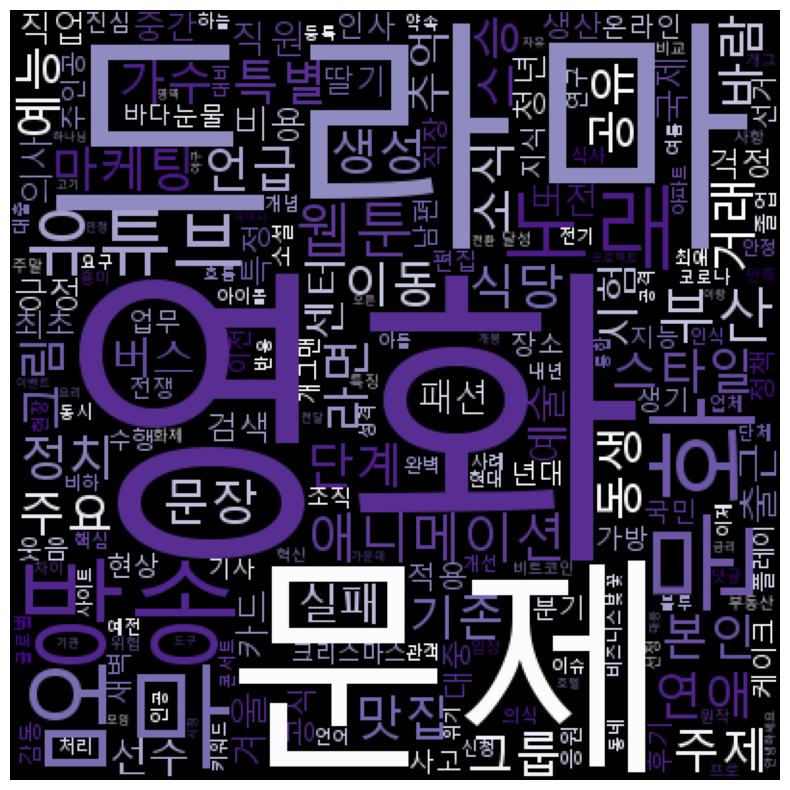

In [25]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Purples')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기